In [1]:
import math
import os
import re
import altair as alt
import numpy as np
import pandas as pd
import scipy.stats
import yaml
import neutcurve
import scipy.stats
print(f"Using `neutcurve` version {neutcurve.__version__}")
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

#import altair themes from /data/custom_analyses_data/theme.py and enable
import theme
alt.themes.register('main_theme', theme.main_theme)
alt.themes.enable('main_theme')
from pathlib import Path

repo_root = Path.cwd().parent
os.chdir(repo_root)
print(os.getcwd())
#print(os.listdir("raw_plate_reader"))
plt.rcParams['svg.fonttype'] = 'none' #from bernadeta, for correct font svg output

Using `neutcurve` version 2.1.0
/fh/fast/bloom_j/computational_notebooks/tmcmahon/2024/02_RSV/RSV_evolution_neut


In [2]:
RSV_1 = pd.read_csv('01_data/combined_frac_infect/RSV_Historical_Sera_1_frac_infect.csv')
RSV_2 = pd.read_csv('01_data/combined_frac_infect/RSV_Historical_Sera_2_frac_infect.csv')

In [3]:
# Remove leading/trailing spaces in the 'virus' column for RSV_1
RSV_1['virus'] = RSV_1['virus'].str.strip()

# Remove leading/trailing spaces in the 'virus' column for RSV_2
RSV_2['virus'] = RSV_2['virus'].str.strip()

# Verify the changes
print(RSV_1['virus'].unique())
RSV_1.head()
print(RSV_2['virus'].unique())
RSV_2.head()

['RSV B N201T' 'RSV B N201S' 'RSV B 1992' 'RSV B 2019' 'RSV B 1982'
 'RSV A 1982' 'RSV B 2024' 'RSV A 2020']
['RSV B N201T' 'RSV B 1992' 'RSV B 2019' 'RSV B 1982' 'RSV B 2024'
 'RSV A 1982' 'RSV A 2020']


,Unnamed: 0,serum,virus,replicate,concentration,well_id,plate_name,experiment_rep,fraction infectivity,input_folder,Unnamed: 9
0,2340,85_1,RSV B N201T,1,0.010000,F2,V2P1,RSV_Historical_Sera_2,0.0446,25.01.23,NaN
1,2341,85_1,RSV B N201T,1,0.003333,F3,V2P1,RSV_Historical_Sera_2,0.1781,25.01.23,NaN
2,2342,85_1,RSV B N201T,1,0.001111,F4,V2P1,RSV_Historical_Sera_2,0.4114,25.01.23,NaN
3,2343,85_1,RSV B N201T,1,0.000370,F5,V2P1,RSV_Historical_Sera_2,0.7541,25.01.23,NaN
4,2344,85_1,RSV B N201T,1,0.000123,F6,V2P1,RSV_Historical_Sera_2,0.9462,25.01.23,NaN


In [4]:
RSV_1_fits = neutcurve.curvefits.CurveFits(
            data=RSV_1,
            fixbottom=0,
            #max_viruses_per_subplot=11
            )
RSV_1_fits.fitParams().to_csv("03_output/processed_data/RSV_Historical_Sera_1_fits.csv")

In [5]:
RSV_1_IC50 = pd.read_csv("03_output/processed_data/RSV_Historical_Sera_1_fits.csv")
RSV_1_IC50['NT50'] = 1 / RSV_1_IC50['ic50']
RSV_1_IC50['Experiment_Rep'] = 1
#RSV_2_IC50.to_csv("03_output/processed_data/RSV_Historical_Sera_2_NT50.csv")

In [6]:
RSV_2_fits = neutcurve.curvefits.CurveFits(
            data=RSV_2,
            fixbottom=0,
            #max_viruses_per_subplot=11
            )
RSV_2_fits.fitParams().to_csv("03_output/processed_data/RSV_Historical_Sera_2_fits.csv")

/fh/fast/bloom_j/software/miniforge3/envs/BloomLab/lib/python3.12/site-packages/neutcurve/hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(
/fh/fast/bloom_j/software/miniforge3/envs/BloomLab/lib/python3.12/site-packages/neutcurve/hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(
/fh/fast/bloom_j/software/miniforge3/envs/BloomLab/lib/python3.12/site-packages/neutcurve/hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


In [7]:
RSV_2_IC50 = pd.read_csv("03_output/processed_data/RSV_Historical_Sera_2_fits.csv")
RSV_2_IC50['NT50'] = 1 / RSV_2_IC50['ic50']
RSV_2_IC50['Experiment_Rep'] = 2
#RSV_2_IC50.to_csv("03_output/processed_data/RSV_Historical_Sera_2_NT50.csv")

In [8]:
RSV_IC50 = pd.concat([RSV_1_IC50, RSV_2_IC50], ignore_index=True)
RSV_IC50.to_csv("03_output/processed_data/RSV_Historical_Sera_NT50.csv")

In [9]:
# Group by virus and serum and calculate the number of replicates
replicate_counts = RSV_IC50.groupby(['virus', 'serum'])['NT50'].size().reset_index(name='replicate_count')

# Calculate geo_mean_NT50 and error bars (standard deviation)
def compute_error_bars(group):
    if len(group) == 1:
        # Only one replicate, so no error bar
        geo_mean = group['NT50'].iloc[0]
        return pd.Series({
            'geo_mean_NT50': geo_mean,
            'lower': geo_mean,  # No error bar
            'upper': geo_mean
        })
    else:
        # Multiple replicates: calculate geometric mean and error bars
        geo_mean = np.exp(np.mean(np.log(group['NT50'][group['NT50'] > 0])))
        std = np.std(np.log(group['NT50'][group['NT50'] > 0]))
        lower = np.exp(np.log(geo_mean) - std)
        upper = np.exp(np.log(geo_mean) + std)
        return pd.Series({
            'geo_mean_NT50': geo_mean,
            'lower': lower,
            'upper': upper
        })

# Function to extract NT50 values for Experiment_Rep 1 and 2
def extract_replicates(group):
    # Initialize default values
    NT50_rep1, NT50_rep2 = np.nan, np.nan
    
    # Check for replicate 1 and replicate 2 values
    if 1 in group['Experiment_Rep'].values:
        NT50_rep1 = group[group['Experiment_Rep'] == 1]['NT50'].values[0]
    if 2 in group['Experiment_Rep'].values:
        NT50_rep2 = group[group['Experiment_Rep'] == 2]['NT50'].values[0]
    
    return pd.Series({'NT50_rep1': NT50_rep1, 'NT50_rep2': NT50_rep2})

# Group by virus and serum and calculate geo_mean and error bars
RSV_IC50_mean = (
    RSV_IC50.groupby(['virus', 'serum'])
    .apply(lambda group: pd.concat([compute_error_bars(group), extract_replicates(group)]))
    .reset_index()
)

# Save to CSV
RSV_IC50_mean.to_csv("03_output/processed_data/RSV_Historical_Sera_NT50_mean_with_error_rep.csv", index=False)


/tmp/ipykernel_27972/3308753889.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.concat([compute_error_bars(group), extract_replicates(group)]))


In [10]:
# Group by virus and serum and calculate the number of replicates
replicate_counts = RSV_IC50.groupby(['virus', 'serum'])['NT50'].size().reset_index(name='replicate_count')

# Calculate geo_mean_NT50 and error bars (standard deviation)
def compute_error_bars(group):
    if len(group) == 1:
        # Only one replicate, so no error bar
        geo_mean = group['NT50'].iloc[0]
        return pd.Series({
            'geo_mean_NT50': geo_mean,
            'lower': geo_mean,  # No error bar
            'upper': geo_mean
        })
    else:
        # Multiple replicates: calculate geometric mean and error bars
        geo_mean = np.exp(np.mean(np.log(group['NT50'][group['NT50'] > 0])))
        std = np.std(np.log(group['NT50'][group['NT50'] > 0]))
        lower = np.exp(np.log(geo_mean) - std)
        upper = np.exp(np.log(geo_mean) + std)
        return pd.Series({
            'geo_mean_NT50': geo_mean,
            'lower': lower,
            'upper': upper
        })

# Group by virus and serum and calculate geo_mean and error bars
RSV_IC50_mean = (
    RSV_IC50.groupby(['virus', 'serum'])
    .apply(compute_error_bars)
    .reset_index()
)

RSV_IC50_mean.to_csv("03_output/processed_data/RSV_Historical_Sera_NT50_mean_with_error.csv", index=False)


/tmp/ipykernel_27972/1956299653.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_error_bars)


In [11]:
unique_viruses = RSV_IC50_mean['virus'].unique()

# Print the result
print(unique_viruses)

['RSV A 1982' 'RSV A 2020' 'RSV B 1982' 'RSV B 1992' 'RSV B 2019'
 'RSV B 2024' 'RSV B N201S' 'RSV B N201T']


In [12]:
# add subtype
subtype_mapping = {
    'RSV A 1982': 'A',
    'RSV A 2020': 'A',
    'RSV B 1982': 'B',
    'RSV B 1992': 'B',
    'RSV B 2019': 'B',
    'RSV B 2024': 'B',
    'RSV B N201S': 'B',
    'RSV B N201T': 'B'
}

# Create the 'subtype' column using the mapping
RSV_IC50_mean['subtype'] = RSV_IC50_mean['virus'].map(subtype_mapping)
#RSV_IC50_mean_combined['subtype'] = RSV_IC50_mean_combined['virus'].map(subtype_mapping)

# Verify the changes
print(RSV_IC50_mean.head())

        virus serum  geo_mean_NT50        lower        upper subtype
0  RSV A 1982  85_1    1675.966889  1412.624393  1988.401889       A
1  RSV A 1982  85_2     395.190096   315.124956   495.597727       A
2  RSV A 1982  85_3    2311.196240  1452.396929  3677.801813       A
3  RSV A 1982  85_4     647.833948   646.591605   649.078678       A
4  RSV A 1982  85_6    1584.375128  1145.762683  2190.893964       A


In [13]:
unique_sera = RSV_IC50_mean['serum'].unique()

# Print the result
print(unique_sera)

['85_1' '85_2' '85_3' '85_4' '85_6' '85_7' '85_8' '86_1' '86_10' '86_12'
 '86_2' '86_4' '86_6' '86_7' '86_8' '86_9' '87_4' '87_7' '87_8' '87_9'
 'BEI_neg']


In [14]:
unique_virus = RSV_IC50_mean['virus'].unique()

# Print the result
print(unique_virus)

['RSV A 1982' 'RSV A 2020' 'RSV B 1982' 'RSV B 1992' 'RSV B 2019'
 'RSV B 2024' 'RSV B N201S' 'RSV B N201T']


## now some plots
line plot by person
before after plot

In [15]:
import altair as alt

# Filter the DataFrame to exclude unwanted serum values
filtered_df = RSV_IC50_mean[~RSV_IC50_mean['serum'].isin(['BEI_neg', 'BEI negative'])]

# Split the data into two subsets based on subtype
subset_A = filtered_df[filtered_df['subtype'] == 'A']
subset_B = filtered_df[filtered_df['subtype'] == 'B']

# Create the chart for subtype A
chart_A = alt.Chart(subset_A).mark_line(
    point=alt.OverlayMarkDef(size=100)
).encode(
    x=alt.X('virus:N', 
            title='RSV pseudovirus', 
            #sort=alt.EncodingSortField('virus', order='descending'), 
            axis=alt.Axis(labelAngle=45)),
    y=alt.Y('geo_mean_NT50:Q', 
            title='Sera neutralization titer (geo_mean_NT50)', 
            scale=alt.Scale(type='log')),
    color=alt.Color('serum:N', title='Serum'),
    tooltip=[
        alt.Tooltip('serum:N', title='Serum'),
        alt.Tooltip('virus:N', title='Virus'),
        alt.Tooltip('geo_mean_NT50:Q', title='geo_mean_NT50')
    ]
).properties(
    width=300,  # Width for subtype A chart
    height=300
)

# Create the chart for subtype B
chart_B = alt.Chart(subset_B).mark_line(
    point=alt.OverlayMarkDef(size=100)
).encode(
    x=alt.X('virus:N', 
            title='RSV pseudovirus', 
            #sort=alt.EncodingSortField('virus', order='descending'), 
            axis=alt.Axis(labelAngle=45)),
    y=alt.Y('geo_mean_NT50:Q', 
            title='',  # Remove title (it's shared with chart A)
            scale=alt.Scale(type='log')),
    color=alt.Color('serum:N', title='Serum'),
    tooltip=[
        alt.Tooltip('serum:N', title='Serum'),
        alt.Tooltip('virus:N', title='Virus'),
        alt.Tooltip('geo_mean_NT50:Q', title='geo_mean_NT50')
    ]
).properties(
    width=600,  # Width for subtype B chart (twice as wide)
    height=300
)

# Combine the two charts horizontally
combined_chart = alt.hconcat(chart_A, chart_B).resolve_scale(
    y='shared'  # Share the y-axis scale between the two charts
)

combined_chart


alt.HConcatChart(...)

## before and after plot

In [16]:
import altair as alt

# Filter the DataFrame to exclude unwanted serum values
filtered_df = RSV_IC50_mean[~RSV_IC50_mean['serum'].isin(['BEI_neg', 'BEI negative'])]

# Define a selection for viruses
virus_selection = alt.selection_point(fields=['virus'], bind='legend', name="Virus Selection")

# Create the median layer (with larger ticks)
def create_median_layer(data):
    return alt.Chart(data).mark_tick(
        thickness=5,  # Thickness of the tick
        size=40,  # Length of the tick
        color='black'
    ).encode(
        x=alt.X('virus:N', title=None),  # X-axis for virus
        y=alt.Y('median(geo_mean_NT50):Q', title=None)  # Median per virus
    ).transform_filter(
        virus_selection  # Apply selection for interactivity
    )

# Create the individual serum line chart
def create_serum_chart(data, width):
    return alt.Chart(data).mark_line(
        point=alt.OverlayMarkDef(size=70, color='grey'),  # Medium grey points
        color='grey',  # Medium grey lines
        opacity=0.5  # Slightly see-through connecting lines
    ).encode(
        x=alt.X('virus:N', title='RSV pseudovirus', axis=alt.Axis(labelAngle=45)),
        y=alt.Y('geo_mean_NT50:Q', 
                title='Sera neutralization titer (geo_mean_NT50)', 
                scale=alt.Scale(type='log')),
        detail='serum:N',  # Ensure lines connect per serum, not virus
        tooltip=[
            alt.Tooltip('serum:N', title='Serum'),
            alt.Tooltip('virus:N', title='Virus'),
            alt.Tooltip('geo_mean_NT50:Q', title='geo_mean_NT50')
        ]
    ).add_params(
        virus_selection  # Add the interactive selection
    ).properties(
        width=width,
        height=300
    )

# Create layered charts for subtypes
chart_A = alt.layer(
    create_serum_chart(filtered_df[filtered_df['subtype'] == 'A'], 300),  # Serum lines
    create_median_layer(filtered_df[filtered_df['subtype'] == 'A'])  # Median ticks
).properties(
    title="Subtype A"
)

chart_B = alt.layer(
    create_serum_chart(filtered_df[filtered_df['subtype'] == 'B'], 600),  # Serum lines
    create_median_layer(filtered_df[filtered_df['subtype'] == 'B'])  # Median ticks
).properties(
    title="Subtype B"
)

# Save the Subtype A chart as an interactive HTML file
#chart_A.save("03_output/plots/Subtype_A_interactive_with_legend.html")

# Save the Subtype B chart as an interactive HTML file
#chart_B.save("03_output/plots/Subtype_B_interactive_with_legend.html")

# Combine the two charts horizontally for viewing in the notebook
combined_chart = alt.hconcat(chart_A, chart_B).resolve_scale(
    y='shared'  # Share the y-axis scale between the two charts
)

combined_chart



alt.HConcatChart(...)

## figure 7 

In [17]:
import altair as alt

# Define a selection for viruses
virus_selection = alt.selection_point(fields=['virus'], bind='legend')

# Filter data to include only specified viruses
filtered_df = filtered_df[filtered_df['virus'].isin([
    "RSV A 1982", "RSV A 2020", 
    "RSV B 1982", "RSV B 1992", "RSV B 2019", "RSV B 2024"
])]

# Create the serum chart with lines and points
def create_serum_chart(data, width, show_y_labels=True):
    base = alt.Chart(data).encode(
        x=alt.X('virus:N', 
                title='RSV pseudovirus', 
                axis=alt.Axis(
                    labelAngle=-90, 
                    labelFontSize=16,  # Increased font size for x-axis text
                    titleFontSize=18  # Increased font size for x-axis title
                )),
        y=alt.Y('geo_mean_NT50:Q', 
                title="Sera Neutralization Titer (NT50)" if show_y_labels else None,  # Y-axis title only on first facet
                scale=alt.Scale(type='log', domain=[200, 50000]),  # Set Y-axis limits
                axis=alt.Axis(
                    labelFontSize=16 if show_y_labels else 0,  # Increase font size, hide labels on second facet
                    titleFontSize=20,  # Increase font size for y-axis title
                    titlePadding=20  # Add spacing between y-axis title and labels
                ) if show_y_labels else alt.Axis(labels=False, ticks=True, domain=True)
        ),
        detail='serum:N',  # Connect lines per serum
        color=alt.Color('virus:N', legend=alt.Legend(title="Virus")),  # Enable legend for virus selection
        tooltip=[
            alt.Tooltip('serum:N', title='Serum'),
            alt.Tooltip('virus:N', title='Virus'),
            alt.Tooltip('geo_mean_NT50:Q', title='geo_mean_NT50')
        ]
    )

    # Add lines and points with visual override for gray
    lines = base.mark_line(opacity=0.5).encode(color=alt.value('grey')).transform_filter(virus_selection)
    points = base.mark_point(size=70, filled=True).encode(color=alt.value('grey')).transform_filter(virus_selection)
    
    return (lines + points).properties(
        width=width,
        height=300
    )

# Create the median layer (with larger ticks)
def create_median_layer(data, show_y_labels=True):
    return alt.Chart(data).mark_tick(
        thickness=5,  # Thickness of the tick
        size=40,  # Length of the tick
        color='black'
    ).encode(
        x=alt.X('virus:N', title=None),  # X-axis for virus
        y=alt.Y('median(geo_mean_NT50):Q', 
                title="Sera Neutralization Titer (NT50)" if show_y_labels else None,  # Y-axis title only on first facet
                scale=alt.Scale(type='log', domain=[200, 50000]),
                axis=alt.Axis(
                    labelFontSize=16 if show_y_labels else 0,  # Increase font size, hide labels on second facet
                    titleFontSize=20,  # Increase font size for y-axis title
                    titlePadding=20  # Add spacing between y-axis title and labels
                ) if show_y_labels else alt.Axis(labels=False, ticks=True, domain=True)
        )
    ).transform_filter(
        virus_selection  # Apply selection for interactivity
    )

# Create charts for subtypes
chart_A = alt.layer(
    create_serum_chart(filtered_df[filtered_df['subtype'] == 'A'], 200, show_y_labels=True),  # Show Y-axis for first facet
    create_median_layer(filtered_df[filtered_df['subtype'] == 'A'], show_y_labels=True)  # Show Y-axis for first facet
).add_params(
    virus_selection  # Add interactive selection at the top level
).properties(
    title="Subtype A"
)

chart_B = alt.layer(
    create_serum_chart(filtered_df[filtered_df['subtype'] == 'B'], 500, show_y_labels=False),  # Hide Y-axis labels but keep axis
    create_median_layer(filtered_df[filtered_df['subtype'] == 'B'], show_y_labels=False)  # Hide Y-axis labels but keep axis
).add_params(
    virus_selection  # Add interactive selection at the top level
).properties(
    title="Subtype B"
)

# Combine charts for viewing in notebook
combined_chart = (
    alt.hconcat(
        chart_A.properties(width=200, height=300),
        chart_B.properties(width=500, height=300)
    )
).resolve_scale(y='shared').resolve_axis(
    y='shared',  # Shared y-axis
    x='independent'  # Ensures x-axis labels are separate for each facet
).configure_title(
    anchor='middle',  # Keeps the title centered
    fontSize=18,  # Increase font size
    dy=-10  # Move title higher to create more white space
)

# Display the final chart
combined_chart.configure_axis(labelFontSize=16, titleFontSize=20).display()

# Save the chart as an interactive HTML file
combined_chart.save("03_output/plots/RSVEvo_historicalsera_neutralization_plot.html")

alt.HConcatChart(...)

## all curves for supplemental figure
- all strains
- just N201S/T

In [18]:
# Load the data
RSV_1 = pd.read_csv('01_data/combined_frac_infect/RSV_Historical_Sera_1_frac_infect.csv')
RSV_2 = pd.read_csv('01_data/combined_frac_infect/RSV_Historical_Sera_2_frac_infect.csv')

# Remove leading/trailing spaces in the 'virus' column
RSV_1['virus'] = RSV_1['virus'].str.strip()
RSV_2['virus'] = RSV_2['virus'].str.strip()

# Append "Replicate 1" and "Replicate 2" to the 'virus' column
RSV_1['virus'] = RSV_1['virus'] + ' Replicate 1'
RSV_2['virus'] = RSV_2['virus'] + ' Replicate 2'

# Combine the dataframes
RSV_combined = pd.concat([RSV_1, RSV_2], ignore_index=True)

# Display the combined dataframe
RSV_combined

,Unnamed: 0,serum,virus,replicate,concentration,well_id,plate_name,experiment_rep,fraction infectivity,input_folder,Unnamed: 9
0,1692,85_1,RSV B N201T Replicate 1,1,0.010000,F2,V3P1,RSV_Historical_Sera_1,0.0113,25.01.23,NaN
1,1693,85_1,RSV B N201T Replicate 1,1,0.003333,F3,V3P1,RSV_Historical_Sera_1,0.2851,25.01.23,NaN
2,1694,85_1,RSV B N201T Replicate 1,1,0.001111,F4,V3P1,RSV_Historical_Sera_1,0.7026,25.01.23,NaN
3,1695,85_1,RSV B N201T Replicate 1,1,0.000370,F5,V3P1,RSV_Historical_Sera_1,1.0700,25.01.23,NaN
4,1696,85_1,RSV B N201T Replicate 1,1,0.000123,F6,V3P1,RSV_Historical_Sera_1,1.2980,25.01.23,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5449,7807,85_8,RSV A 2020 Replicate 2,2,0.000309,C6,V2P4,RSV_Historical_Sera_2,0.3064,24.10.17_RSVNeut_Sera_Evo2,NaN
5450,7808,85_8,RSV A 2020 Replicate 2,2,0.000103,C7,V2P4,RSV_Historical_Sera_2,0.6397,24.10.17_RSVNeut_Sera_Evo2,NaN
5451,7809,85_8,RSV A 2020 Replicate 2,2,0.000034,C8,V2P4,RSV_Historical_Sera_2,0.7049,24.10.17_RSVNeut_Sera_Evo2,NaN
5452,7810,85_8,RSV A 2020 Replicate 2,2,0.000011,C9,V2P4,RSV_Historical_Sera_2,0.7740,24.10.17_RSVNeut_Sera_Evo2,NaN


In [19]:
RSV_combined = RSV_combined[~RSV_combined['serum'].isin(['BEI_neg', 'BEI negative'])]

# Define virus groups
historic_viruses = ['RSV B 1992', 'RSV B 2019', 'RSV B 1982', 'RSV A 1982', 'RSV B 2024', 'RSV A 2020']
escape_viruses = ['RSV B N201T', 'RSV B N201S']

# Filter RSV_combined into two separate dataframes
RSV_historic = RSV_combined[RSV_combined['virus'].str.contains('|'.join(historic_viruses))]
RSV_escape = RSV_combined[RSV_combined['virus'].str.contains('|'.join(escape_viruses))]

RSV_historic.head()
print(RSV_historic['virus'].unique())

RSV_escape.head()
print(RSV_escape['virus'].unique())

['RSV B 1992 Replicate 1' 'RSV B 2019 Replicate 1'
 'RSV B 1982 Replicate 1' 'RSV A 1982 Replicate 1'
 'RSV B 2024 Replicate 1' 'RSV A 2020 Replicate 1'
 'RSV B 1992 Replicate 2' 'RSV B 2019 Replicate 2'
 'RSV B 1982 Replicate 2' 'RSV B 2024 Replicate 2'
 'RSV A 1982 Replicate 2' 'RSV A 2020 Replicate 2']
['RSV B N201T Replicate 1' 'RSV B N201S Replicate 1'
 'RSV B N201T Replicate 2']


In [20]:
RSV_historic_fits = neutcurve.curvefits.CurveFits(
            data=RSV_historic,
            fixbottom=0,
            #max_viruses_per_subplot=11
            )
#RSV_1_fits.fitParams().to_csv("03_output/processed_data/RSV_Historical_Sera_1_fits.csv")

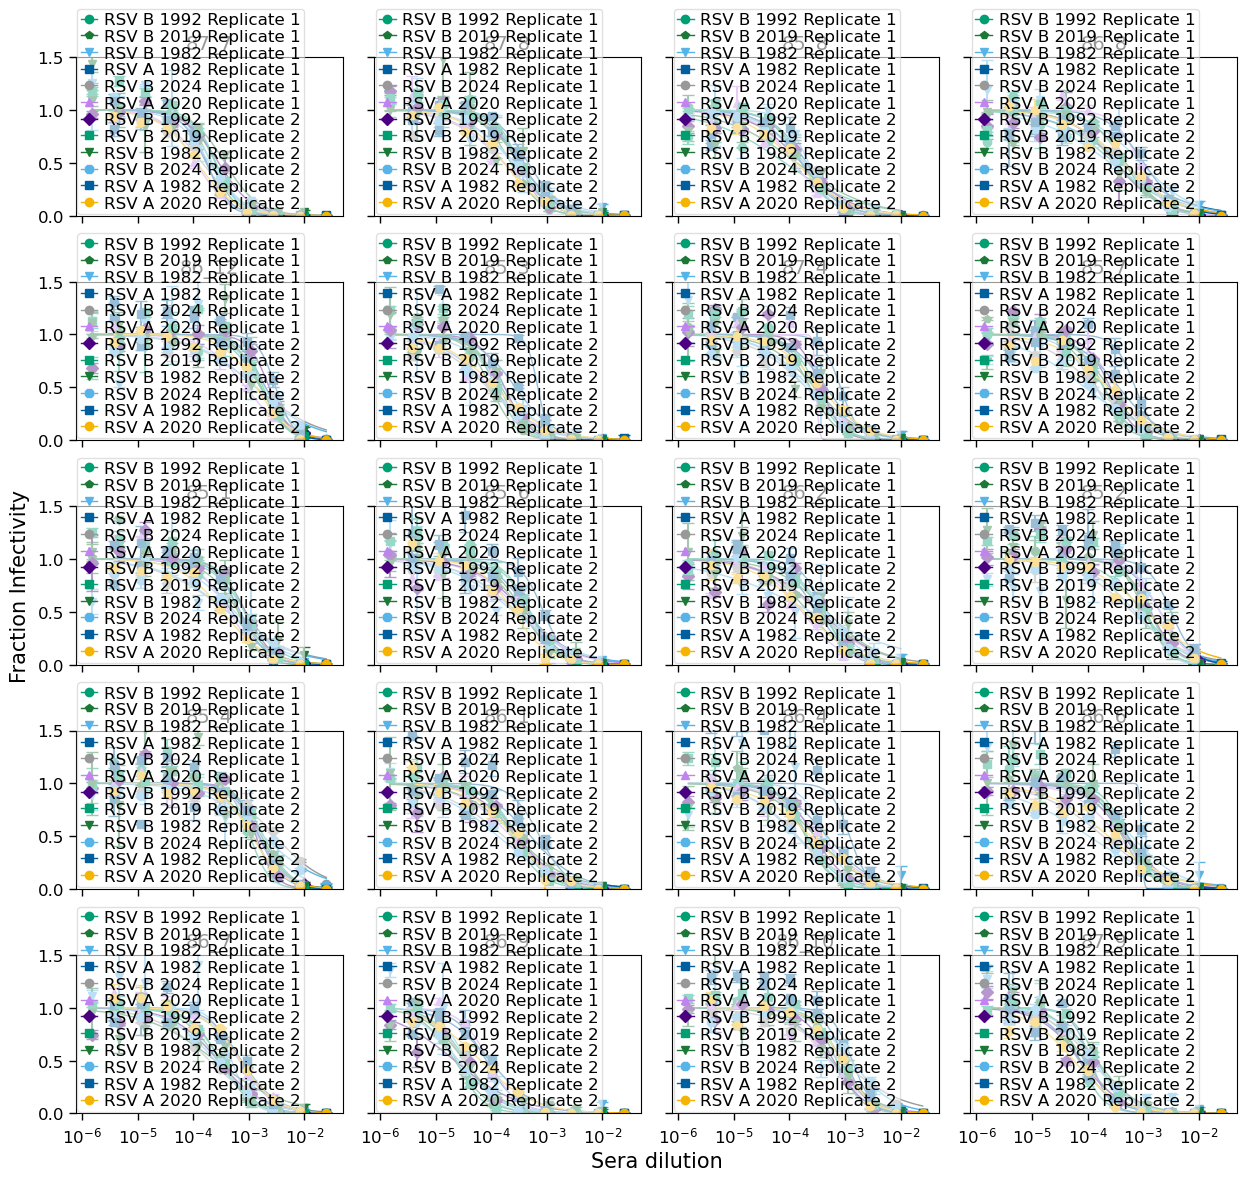

In [21]:
fig, axes = RSV_historic_fits.plotSera(
    #sera=['Palivizumab','Nirsevimab', 'Suptavumab', 'hRSV90', 'Clesrovimab', 'AM14', 'MPE8'], 
    #viruses=['RSV A 1982 Replicate 1','RSV A 1982 Replicate 2','RSV A 2020 Replicate 1' , 'RSV A 2020 Replicate 2' ,'RSV B 1982 Replicate 1', 'RSV B 1982 Replicate 2','RSV B 1992 Replicate 1', 'RSV B 1992 Replicate 2','RSV B 2019 Replicate 1','RSV B 2019 Replicate 2', 'RSV B 2024 Replicate 1', 'RSV B 2024 Replicate 2'],
    xlabel='Sera dilution', 
    ylabel="Fraction Infectivity",
    max_viruses_per_subplot=12, 
    colors=['#009E73','#1B7837','#56B4E9', '#005F9E','#999999','#C083F0','#4B0082',
        '#009E73','#1B7837','#56B4E9', '#005F9E','#F4B400', '#4B0082', '#C083F0',
        '#A3D5FF','#0A2472','#A7D397','#1B4D3E', '#999999', '#4B0082', '#D8BFD8',
        '#56B4E9', '#0072B2', '#009E73','#1B7837', '#000000', '#999999','#872BB2',
            '#1B7837', '#009E73', '#999999', '#872BB2', '#FF8D3D', '#FFDA4D'], 
    markers=['o', 'p', 'v', 's', 'o', '^', 'D', 's', 'v', '8', 's','o'],
    draw_in_bounds=True, 
    attempt_shared_legend=True,
    #sharex=False,
    ncol=4
)

# Ensure we correctly iterate over all subplot axes
if isinstance(axes, np.ndarray):
    for ax in axes.flatten():  # Flatten in case it's a grid
        ax.set_ylim(0, 1.5)  # Limits y-axis from 0 to 1.5
else:
    axes.set_ylim(0, 1.5)  # If it's a single axis object

# Save the figure
fig.savefig('03_output/plots/Supplemental_Curves_Historic_Sera.svg', bbox_inches='tight')

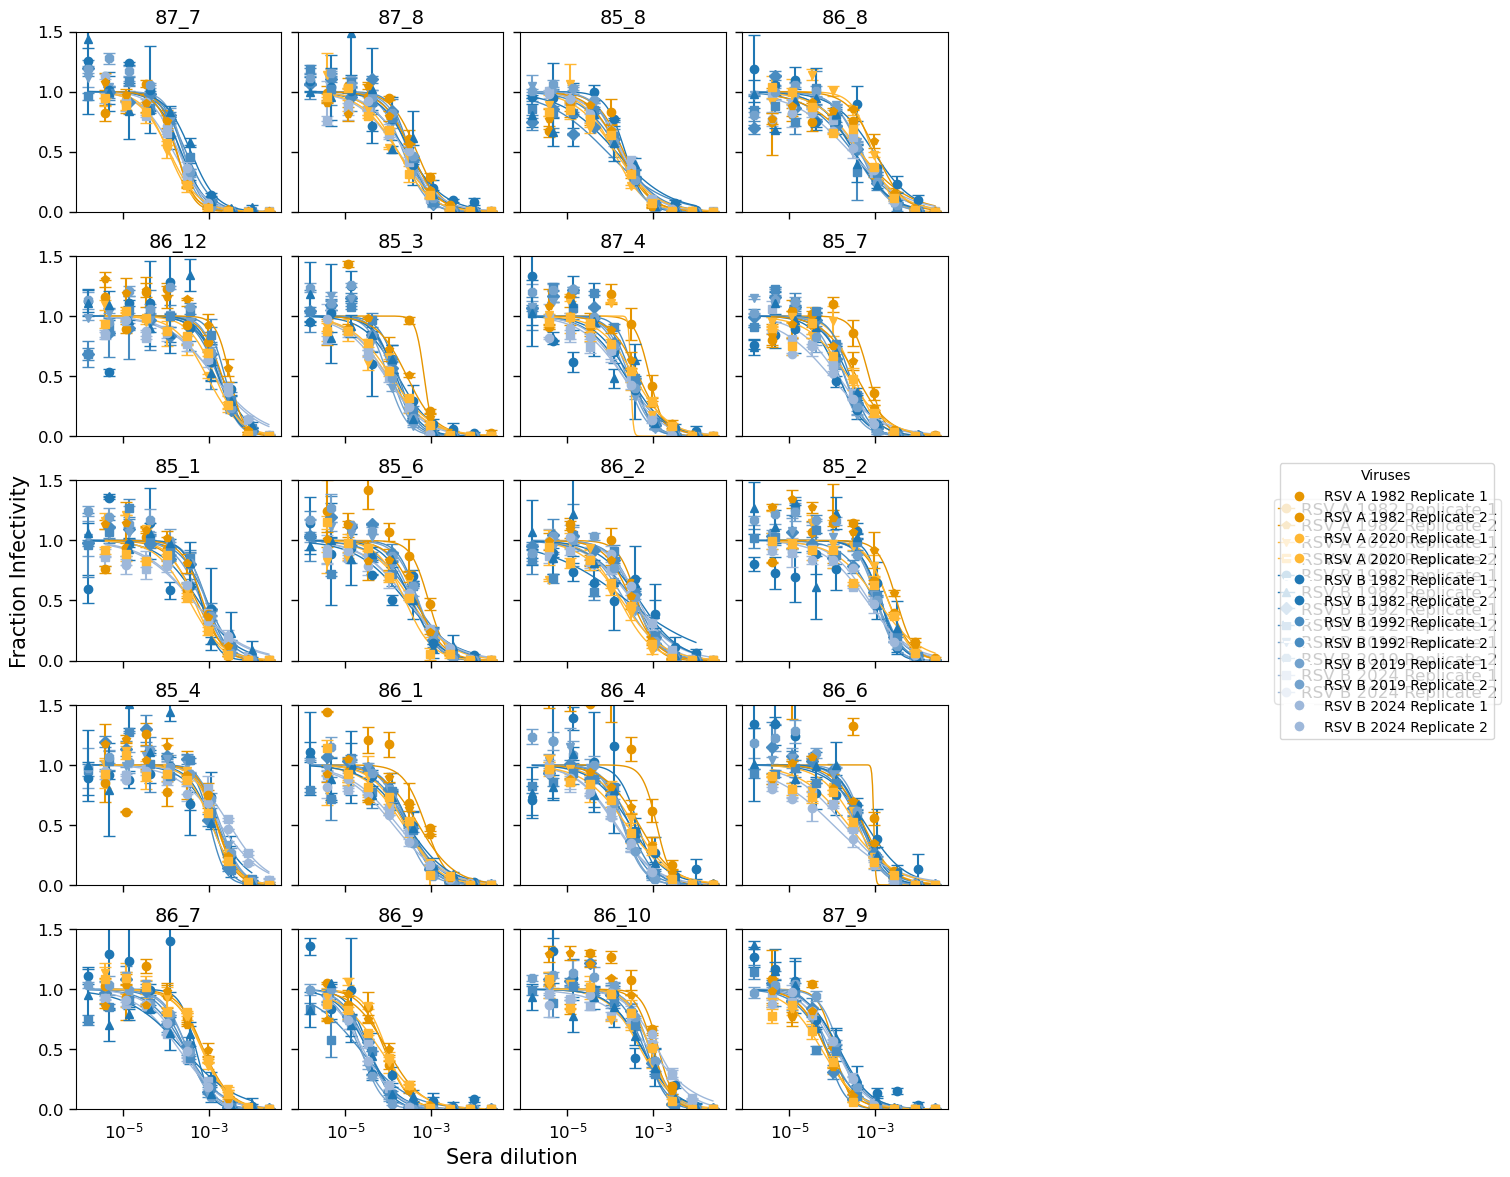

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Plot using neutcurve's plotSera method
fig, axes = RSV_historic_fits.plotSera(
    viruses=[
        'RSV A 1982 Replicate 1', 'RSV A 1982 Replicate 2',
        'RSV A 2020 Replicate 1', 'RSV A 2020 Replicate 2',
        'RSV B 1982 Replicate 1', 'RSV B 1982 Replicate 2',
        'RSV B 1992 Replicate 1', 'RSV B 1992 Replicate 2',
        'RSV B 2019 Replicate 1', 'RSV B 2019 Replicate 2',
        'RSV B 2024 Replicate 1', 'RSV B 2024 Replicate 2'
    ],
    xlabel='Sera dilution',
    ylabel="Fraction Infectivity",
    max_viruses_per_subplot=12,
    colors=[
        '#e69500', '#e69500', #A82
        '#ffb733', '#ffb733', #A2024
        '#1f77b4', '#1f77b4', #B82
        '#498cc1', '#498cc1', 
        '#73a2cd', '#73a2cd', 
        '#9eb8da', '#9eb8da'], #B2024
    markers=['o', 'p', 'v', 's', 'o', '^', 'D', 's', 'v', '8', 's', 'o'],
    draw_in_bounds=True,
    ncol=4
)

# Ensure we correctly iterate over all subplot axes and remove individual legends
if isinstance(axes, np.ndarray):
    for ax in axes.flatten():
        ax.set_ylim(0, 1.5)
        ax.legend().set_visible(False)  # Remove legends from individual subplots
else:
    axes.set_ylim(0, 1.5)
    axes.legend().set_visible(False)

# Adjust figure size to make space for the legend
fig.subplots_adjust(right=0.75)

# Manually create a shared legend
legend_labels = [
    'RSV A 1982 Replicate 1', 'RSV A 1982 Replicate 2',
    'RSV A 2020 Replicate 1', 'RSV A 2020 Replicate 2',
    'RSV B 1982 Replicate 1', 'RSV B 1982 Replicate 2',
    'RSV B 1992 Replicate 1', 'RSV B 1992 Replicate 2',
    'RSV B 2019 Replicate 1', 'RSV B 2019 Replicate 2',
    'RSV B 2024 Replicate 1', 'RSV B 2024 Replicate 2'
]

legend_colors = [
        '#e69500', '#e69500', #A82
        '#ffb733', '#ffb733', #A2024
        '#1f77b4', '#1f77b4', #B82
        '#498cc1', '#498cc1', 
        '#73a2cd', '#73a2cd', 
        '#9eb8da', '#9eb8da'
]

# Generate legend handles manually using Matplotlib's Line2D
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=label)
                  for color, label in zip(legend_colors, legend_labels)]

# Add shared legend outside the figure
fig.legend(handles=legend_handles, loc="center left", bbox_to_anchor=(1, 0.5), title="Viruses")

# Save the figure
fig.savefig('03_output/plots/Supplemental_Curves_Historic_Sera.svg', bbox_inches='tight')

# Show the final plot
plt.show()


## **supplemental figure both reps**
- all strains 
- just N201S/T 

In [23]:
# Load the data
RSV_1 = pd.read_csv('01_data/combined_frac_infect/RSV_Historical_Sera_1_frac_infect.csv')
RSV_2 = pd.read_csv('01_data/combined_frac_infect/RSV_Historical_Sera_2_frac_infect.csv')

# Remove leading/trailing spaces in the 'virus' column
RSV_1['virus'] = RSV_1['virus'].str.strip()
RSV_2['virus'] = RSV_2['virus'].str.strip()

In [24]:
RSV_1 = RSV_1[~RSV_1['serum'].isin(['BEI_neg', 'BEI negative'])]
RSV_2 = RSV_2[~RSV_2['serum'].isin(['BEI_neg', 'BEI negative'])]

# Define virus groups
historic_viruses = ['RSV B 1992', 'RSV B 2019', 'RSV B 1982', 'RSV A 1982', 'RSV B 2024', 'RSV A 2020']
escape_viruses = ['RSV B N201T', 'RSV B N201S']

# Filter RSV into two separate dataframes
RSV_historic_1 = RSV_1[RSV_1['virus'].str.contains('|'.join(historic_viruses))]
RSV_escape_1 = RSV_1[RSV_1['virus'].str.contains('|'.join(escape_viruses))]
RSV_historic_2 = RSV_2[RSV_2['virus'].str.contains('|'.join(historic_viruses))]
RSV_escape_2 = RSV_2[RSV_2['virus'].str.contains('|'.join(escape_viruses))]

RSV_historic_1.head()
print(RSV_historic_1['virus'].unique())

RSV_escape_1.head()
print(RSV_escape_1['virus'].unique())

['RSV B 1992' 'RSV B 2019' 'RSV B 1982' 'RSV A 1982' 'RSV B 2024'
 'RSV A 2020']
['RSV B N201T' 'RSV B N201S']


## representative strains rep 2

In [25]:
RSV_historic_fits_2 = neutcurve.curvefits.CurveFits(
            data=RSV_2,
            fixbottom=0,
            #max_viruses_per_subplot=11
            )
#RSV_1_fits.fitParams().to_csv("03_output/processed_data/RSV_Historical_Sera_1_fits.csv")

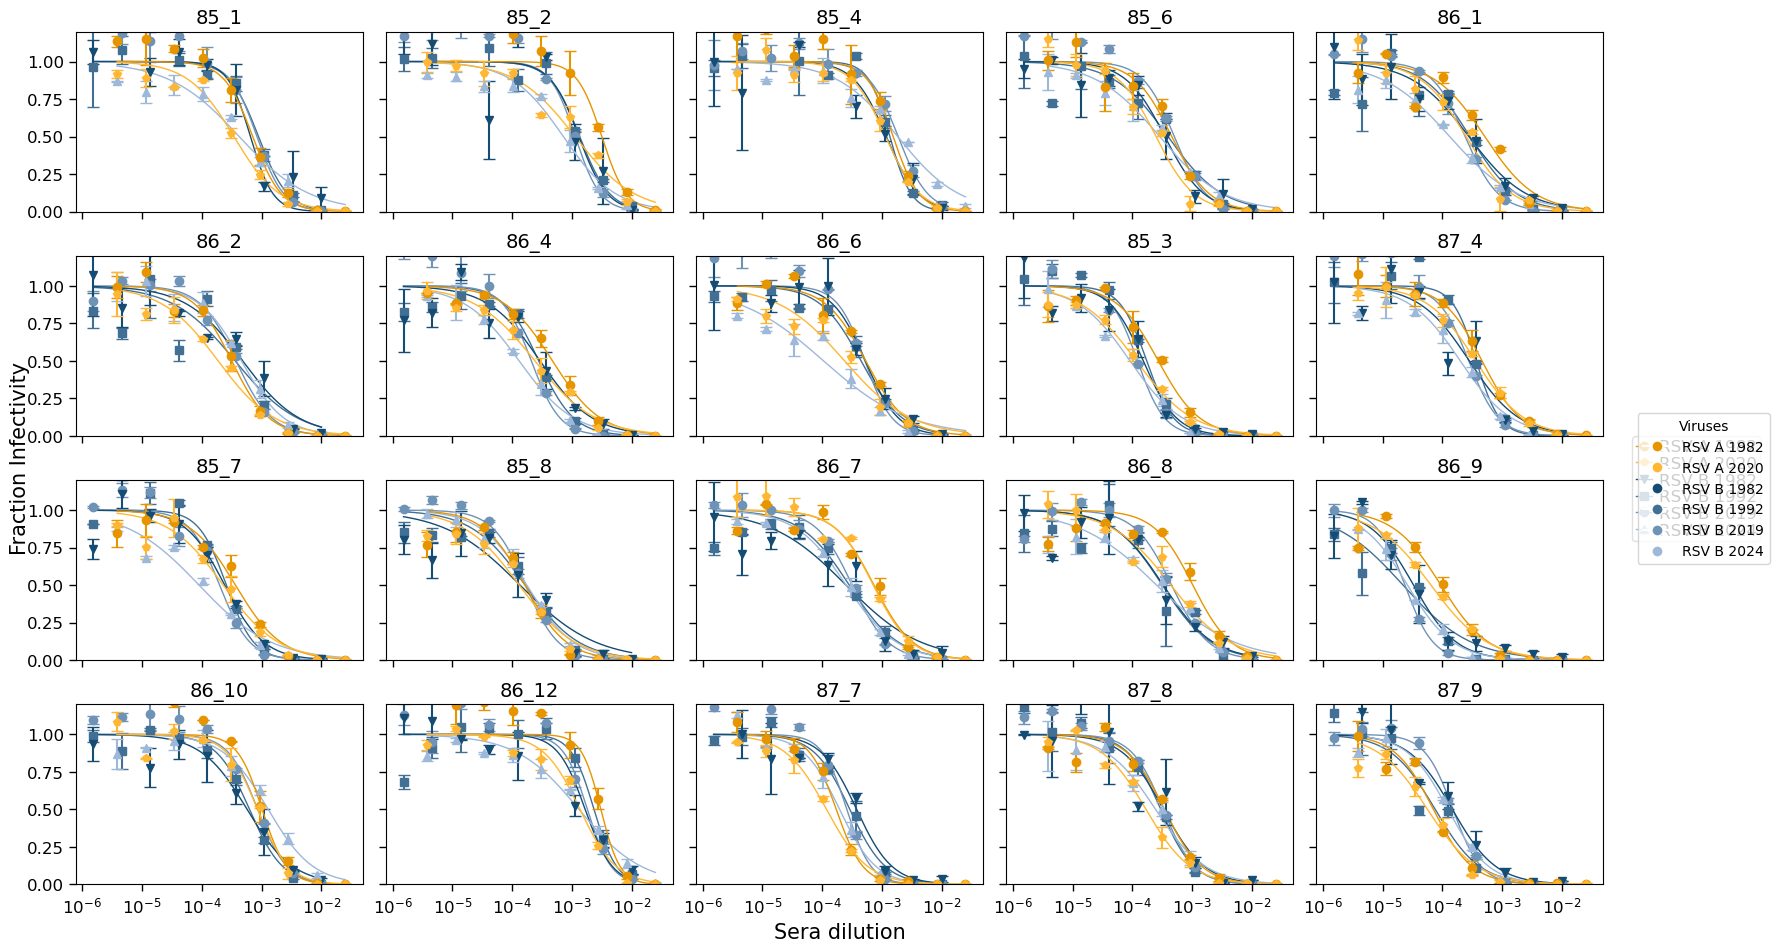

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Plot using neutcurve's plotSera method
fig, axes = RSV_historic_fits_2.plotSera(
    viruses=[
        'RSV A 1982', 
        'RSV A 2020', 
        'RSV B 1982', 
        'RSV B 1992', 
        'RSV B 2019', 
        'RSV B 2024',
    ],
    xlabel='Sera dilution',
    ylabel="Fraction Infectivity",
    max_viruses_per_subplot=12,
    colors=[
        '#e69500',  # A82
        '#ffb733',  # A2024
        '#144c73',  # B82
        '#427095',
        '#6f93b7',
        '#9eb8da'   # B2024
    ],
    markers=['o', 'p', 'v', 's', 'o', '^', 'D', 's', 'v', '8', 's', 'o'],
    draw_in_bounds=True,
    ncol=5
)

# Increase figure width slightly to match the H3 plot sizing
fig.set_size_inches(fig.get_size_inches()[0] * 1.05, fig.get_size_inches()[1])  

# Remove legends from individual subplots
if isinstance(axes, np.ndarray):
    for ax in axes.flatten():
        ax.set_ylim(0, 1.2)
        ax.legend().set_visible(False)  
else:
    axes.set_ylim(0, 1.2)
    axes.legend().set_visible(False)

# Manually create a shared legend
legend_labels = [
    'RSV A 1982', 
    'RSV A 2020', 
    'RSV B 1982', 
    'RSV B 1992', 
    'RSV B 2019', 
    'RSV B 2024'
]

legend_colors = [
    '#e69500',  # A82
    '#ffb733',  # A2024
    '#144c73',  # B82
    '#427095',
    '#6f93b7',
    '#9eb8da'   # B2024
]

# Generate legend handles manually using Matplotlib's Line2D
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=label)
                  for color, label in zip(legend_colors, legend_labels)]

# Add shared legend
fig.legend(handles=legend_handles, loc="center left", bbox_to_anchor=(1, 0.5), title="Viruses")

# Save and show the figure
fig.savefig('03_output/plots/Supplemental_Curves_Historic_Sera_rep2.svg', bbox_inches='tight')

plt.show()


## representative strains rep 1

In [27]:
RSV_historic_fits_1 = neutcurve.curvefits.CurveFits(
            data=RSV_1,
            fixbottom=0,
            #max_viruses_per_subplot=11
            )
#RSV_1_fits.fitParams().to_csv("03_output/processed_data/RSV_Historical_Sera_1_fits.csv")

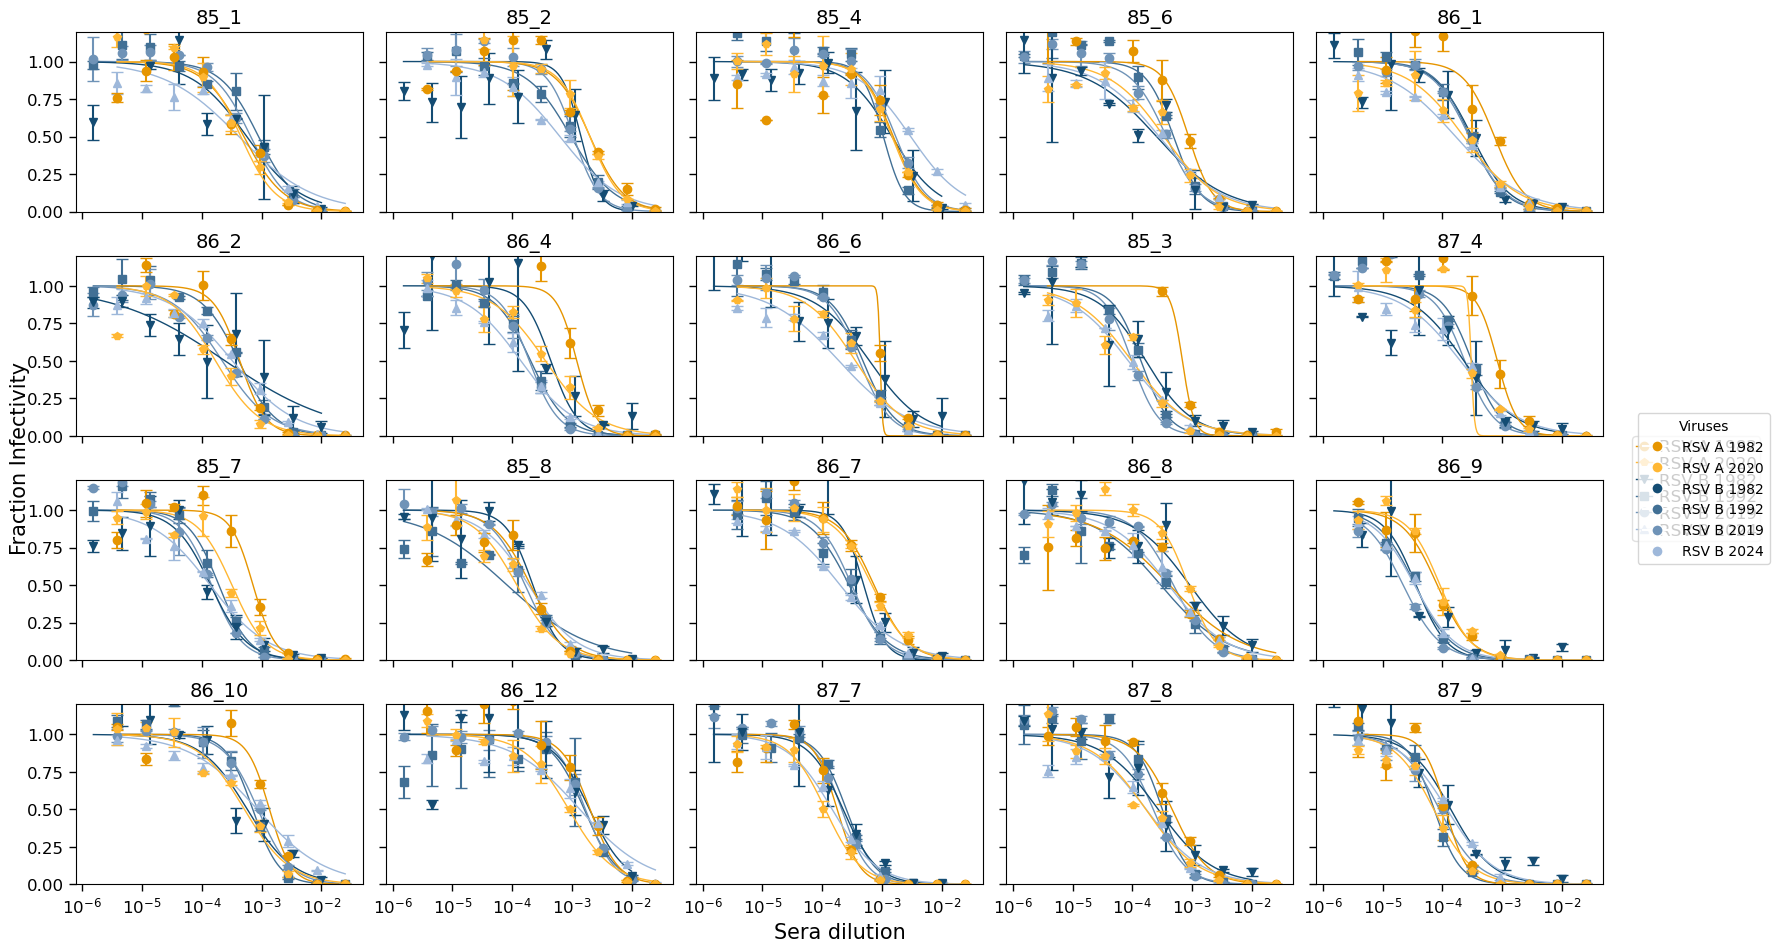

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Plot using neutcurve's plotSera method
fig, axes = RSV_historic_fits_1.plotSera(
    viruses=[
        'RSV A 1982', 
        'RSV A 2020', 
        'RSV B 1982', 
        'RSV B 1992', 
        'RSV B 2019', 
        'RSV B 2024',
    ],
    xlabel='Sera dilution',
    ylabel="Fraction Infectivity",
    max_viruses_per_subplot=12,
    colors=[
        '#e69500',  # A82
        '#ffb733',  # A2024
        '#144c73',  # B82
        '#427095',
        '#6f93b7',
        '#9eb8da'   # B2024
    ],
    markers=['o', 'p', 'v', 's', 'o', '^', 'D', 's', 'v', '8', 's', 'o'],
    draw_in_bounds=True,
    ncol=5
)

# Increase figure width slightly to match the H3 plot sizing
fig.set_size_inches(fig.get_size_inches()[0] * 1.05, fig.get_size_inches()[1])  

# Remove legends from individual subplots
if isinstance(axes, np.ndarray):
    for ax in axes.flatten():
        ax.set_ylim(0, 1.2)
        ax.legend().set_visible(False)  
else:
    axes.set_ylim(0, 1.2)
    axes.legend().set_visible(False)

# Manually create a shared legend
legend_labels = [
    'RSV A 1982', 
    'RSV A 2020', 
    'RSV B 1982', 
    'RSV B 1992', 
    'RSV B 2019', 
    'RSV B 2024'
]

legend_colors = [
    '#e69500',  # A82
    '#ffb733',  # A2024
    '#144c73',  # B82
    '#427095',
    '#6f93b7',
    '#9eb8da'   # B2024
]

# Generate legend handles manually using Matplotlib's Line2D
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=label)
                  for color, label in zip(legend_colors, legend_labels)]

# Add shared legend
fig.legend(handles=legend_handles, loc="center left", bbox_to_anchor=(1, 0.5), title="Viruses")

# Save and show the figure
fig.savefig('03_output/plots/Supplemental_Curves_Historic_Sera_rep1.svg', bbox_inches='tight')

plt.show()

## escape strains rep 1

In [29]:
# Load the data
RSV_1 = pd.read_csv('01_data/combined_frac_infect/RSV_Historical_Sera_1_frac_infect.csv')
RSV_2 = pd.read_csv('01_data/combined_frac_infect/RSV_Historical_Sera_2_frac_infect.csv')

# Remove leading/trailing spaces in the 'virus' column
RSV_1['virus'] = RSV_1['virus'].str.strip()
RSV_2['virus'] = RSV_2['virus'].str.strip()

# Append "Replicate 1" and "Replicate 2" to the 'virus' column
RSV_1['virus'] = RSV_1['virus'] + ' Replicate 1'
RSV_2['virus'] = RSV_2['virus'] + ' Replicate 2'

# Combine the dataframes
RSV_combined = pd.concat([RSV_1, RSV_2], ignore_index=True)

# Display the combined dataframe
RSV_combined

,Unnamed: 0,serum,virus,replicate,concentration,well_id,plate_name,experiment_rep,fraction infectivity,input_folder,Unnamed: 9
0,1692,85_1,RSV B N201T Replicate 1,1,0.010000,F2,V3P1,RSV_Historical_Sera_1,0.0113,25.01.23,NaN
1,1693,85_1,RSV B N201T Replicate 1,1,0.003333,F3,V3P1,RSV_Historical_Sera_1,0.2851,25.01.23,NaN
2,1694,85_1,RSV B N201T Replicate 1,1,0.001111,F4,V3P1,RSV_Historical_Sera_1,0.7026,25.01.23,NaN
3,1695,85_1,RSV B N201T Replicate 1,1,0.000370,F5,V3P1,RSV_Historical_Sera_1,1.0700,25.01.23,NaN
4,1696,85_1,RSV B N201T Replicate 1,1,0.000123,F6,V3P1,RSV_Historical_Sera_1,1.2980,25.01.23,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5449,7807,85_8,RSV A 2020 Replicate 2,2,0.000309,C6,V2P4,RSV_Historical_Sera_2,0.3064,24.10.17_RSVNeut_Sera_Evo2,NaN
5450,7808,85_8,RSV A 2020 Replicate 2,2,0.000103,C7,V2P4,RSV_Historical_Sera_2,0.6397,24.10.17_RSVNeut_Sera_Evo2,NaN
5451,7809,85_8,RSV A 2020 Replicate 2,2,0.000034,C8,V2P4,RSV_Historical_Sera_2,0.7049,24.10.17_RSVNeut_Sera_Evo2,NaN
5452,7810,85_8,RSV A 2020 Replicate 2,2,0.000011,C9,V2P4,RSV_Historical_Sera_2,0.7740,24.10.17_RSVNeut_Sera_Evo2,NaN


In [30]:
RSV_combined = RSV_combined[~RSV_combined['serum'].isin(['BEI_neg', 'BEI negative'])]

# Define virus groups
historic_viruses = ['RSV B 1992', 'RSV B 2019', 'RSV B 1982', 'RSV A 1982', 'RSV B 2024', 'RSV A 2020']
escape_viruses = ['RSV B N201T', 'RSV B N201S']

# Filter RSV_combined into two separate dataframes
RSV_historic = RSV_combined[RSV_combined['virus'].str.contains('|'.join(historic_viruses))]
RSV_escape = RSV_combined[RSV_combined['virus'].str.contains('|'.join(escape_viruses))]

RSV_historic.head()
print(RSV_historic['virus'].unique())

RSV_escape.head()
print(RSV_escape['virus'].unique())

['RSV B 1992 Replicate 1' 'RSV B 2019 Replicate 1'
 'RSV B 1982 Replicate 1' 'RSV A 1982 Replicate 1'
 'RSV B 2024 Replicate 1' 'RSV A 2020 Replicate 1'
 'RSV B 1992 Replicate 2' 'RSV B 2019 Replicate 2'
 'RSV B 1982 Replicate 2' 'RSV B 2024 Replicate 2'
 'RSV A 1982 Replicate 2' 'RSV A 2020 Replicate 2']
['RSV B N201T Replicate 1' 'RSV B N201S Replicate 1'
 'RSV B N201T Replicate 2']


In [31]:
RSV_escape_fits = neutcurve.curvefits.CurveFits(
            data=RSV_escape,
            fixbottom=0,
            #max_viruses_per_subplot=11
            )
#RSV_1_fits.fitParams().to_csv("03_output/processed_data/RSV_Historical_Sera_1_fits.csv")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Plot using neutcurve's plotSera method
fig, axes = RSV_escape_fits.plotSera(
    viruses=[
        'RSV B N201T Replicate 1', 
        'RSV B N201T Replicate 2',
        'RSV B N201S Replicate 1',
    ],
    xlabel='Sera dilution',
    ylabel="Fraction Infectivity",
    max_viruses_per_subplot=12,
    colors=[
        '#4d2a7c',  # N201T
        '#4d2a7c',  # N201T
        '#aa86bd'   # N201S
    ],
    markers=['o', 'p', 'v', 's', 'o', '^', 'D', 's', 'v', '8', 's', 'o'],
    draw_in_bounds=True,
    ncol=4
)

# Increase figure width slightly to match the other plots
fig.set_size_inches(fig.get_size_inches()[0] * 1.05, fig.get_size_inches()[1])  

# Remove legends from individual subplots
if isinstance(axes, np.ndarray):
    for ax in axes.flatten():
        ax.set_ylim(0, 1.2)
        ax.legend().set_visible(False)  
else:
    axes.set_ylim(0, 1.2)
    axes.legend().set_visible(False)

# Manually create a shared legend
legend_labels = [
    'RSV B N201T OQ279862 Replicate 1', 
    'RSV B N201T OQ279862 Replicate 2',
    'RSV B N201S OR795252 Replicate 1'
]

legend_colors = [
    '#4d2a7c',  # N201T
    '#4d2a7c',  # N201T
    '#aa86bd'   # N201S
]

# Generate legend handles manually using Matplotlib's Line2D
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=label)
                  for color, label in zip(legend_colors, legend_labels)]

# Add shared legend
fig.legend(handles=legend_handles, loc="center left", bbox_to_anchor=(1, 0.5), title="Viruses")

# Save and show the figure
fig.savefig('03_output/plots/Supplemental_Curves_Escape_Sera_AllReps.svg', bbox_inches='tight')

plt.show()


## escape strains rep 2

In [ ]:
RSV_escape_fits_2 = neutcurve.curvefits.CurveFits(
            data=RSV_2,
            fixbottom=0,
            #max_viruses_per_subplot=11
            )
#RSV_1_fits.fitParams().to_csv("03_output/processed_data/RSV_Historical_Sera_1_fits.csv")

In [ ]:
unique 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Plot using neutcurve's plotSera method
fig, axes = RSV_escape_fits_2.plotSera(
    viruses=[
        'RSV B N201T', 
        'RSV B N201S',
    ],
    xlabel='Sera dilution',
    ylabel="Fraction Infectivity",
    max_viruses_per_subplot=12,
    colors=[
        '#4d2a7c',  # N201T
        '#aa86bd'   # N201S
    ],
    markers=['o', 'p', 'v', 's', 'o', '^', 'D', 's', 'v', '8', 's', 'o'],
    draw_in_bounds=True,
    ncol=4
)

# Increase figure width slightly to match the other plots
fig.set_size_inches(fig.get_size_inches()[0] * 1.05, fig.get_size_inches()[1])  

# Remove legends from individual subplots
if isinstance(axes, np.ndarray):
    for ax in axes.flatten():
        ax.set_ylim(0, 1.2)
        ax.legend().set_visible(False)  
else:
    axes.set_ylim(0, 1.2)
    axes.legend().set_visible(False)

# Manually create a shared legend
legend_labels = [
    'RSV B N201T OQ279862', 
    'RSV B N201S OR795252'
]

legend_colors = [
    '#4d2a7c',  # N201T
    '#aa86bd'   # N201S
]

# Generate legend handles manually using Matplotlib's Line2D
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=label)
                  for color, label in zip(legend_colors, legend_labels)]

# Add shared legend
fig.legend(handles=legend_handles, loc="center left", bbox_to_anchor=(1, 0.5), title="Viruses")

# Save and show the figure
fig.savefig('03_output/plots/Supplemental_Curves_Escape_Sera_rep2.svg', bbox_inches='tight')

plt.show()
